# Описание проекта

Сеть фитнес-центров «Культурист-датасаентист» разрабатывает стратегию взаимодействия с клиентами на основе аналитических данных. Распространённая проблема фитнес-клубов и других сервисов — отток клиентов. Для фитнес-центра можно считать, что клиент попал в отток, если за последний месяц ни разу не посетил спортзал. Чтобы бороться с оттоком, отдел по работе с клиентами «Культуриста-датасаентиста» перевёл в электронный вид множество клиентских анкет. Ваша задача — провести анализ и подготовить план действий по удержанию клиентов. А именно:

- научиться прогнозировать вероятность оттока (на уровне следующего месяца) для каждого клиента;
- сформировать типичные портреты клиентов: выделить несколько наиболее ярких групп и охарактеризовать их основные свойства;
- проанализировать основные признаки, наиболее сильно влияющие на отток;
- сформулировать основные выводы и разработать рекомендации по повышению качества работы с клиентами:
 - 1) выделить целевые группы клиентов;
 - 2) предложить меры по снижению оттока;
 - 3) определить другие особенности взаимодействия с клиентами.
 
# Описание данных

«Культурист-датасаентист» предоставил сведения в csv-файлах. Заказчик подготовил выгрузку, которая содержит данные на месяц до оттока и факт оттока на определённый месяц. Набор данных включает следующие поля:

- 'Churn' — факт оттока в текущем месяце (данные клиента за предыдущий до проверки факта оттока месяц);
- 'gender' — пол;
- 'Near_Location' — проживание или работа в районе, где находится фитнес-центр;
- 'Partner' — сотрудник компании-партнёра клуба (сотрудничество с компаниями, чьи сотрудники могут получать скидки на абонемент — в таком случае фитнес-центр хранит информацию о работодателе клиента);
- Promo_friends — факт первоначальной записи в рамках акции «приведи друга» (использовал промо-код от знакомого при оплате первого абонемента);
- 'Phone' — наличие контактного телефона;
- 'Age' — возраст;
- 'Lifetime' — время с момента первого обращения в фитнес-центр (в месяцах).
 
Информация на основе журнала посещений, покупок и информация о текущем статусе абонемента клиента:
 
- 'Contract_period' — длительность текущего действующего абонемента (месяц, 3 месяца, 6 месяцев, год);
- 'Month_to_end_contract' — срок до окончания текущего действующего абонемента (в месяцах);
- 'Group_visits' — факт посещения групповых занятий;
- 'Avg_class_frequency_total' — средняя частота посещений в неделю за все время с начала действия абонемента;
- 'Avg_class_frequency_current_month' — средняя частота посещений в неделю за предыдущий месяц;
- 'Avg_additional_charges_total' — суммарная выручка от других услуг фитнес-центра: кафе, спорт-товары, косметический и массажный салон.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from scipy.cluster.hierarchy import dendrogram, linkage 
from sklearn.cluster import KMeans
import warnings
warnings.filterwarnings('ignore')

## Загрузка и предобработка данных

In [2]:
df = pd.read_csv('/datasets/gym_churn.csv')
df.head(10)

,gender,Near_Location,Partner,Promo_friends,Phone,Contract_period,Group_visits,Age,Avg_additional_charges_total,Month_to_end_contract,Lifetime,Avg_class_frequency_total,Avg_class_frequency_current_month,Churn
0,1,1,1,1,0,6,1,29,14.227470,5.0,3,0.020398,0.000000,0
1,0,1,0,0,1,12,1,31,113.202938,12.0,7,1.922936,1.910244,0
2,0,1,1,0,1,1,0,28,129.448479,1.0,2,1.859098,1.736502,0
3,0,1,1,1,1,12,1,33,62.669863,12.0,2,3.205633,3.357215,0
4,1,1,1,1,1,1,0,26,198.362265,1.0,3,1.113884,1.120078,0
5,1,1,0,0,1,1,1,34,450.743960,1.0,3,2.623477,2.637007,0
6,1,1,1,1,0,6,1,32,94.266389,6.0,2,1.138941,1.277242,0
7,0,1,0,0,1,1,0,30,217.786641,1.0,0,1.213502,1.049387,1
8,1,1,1,1,1,1,1,23,45.409909,1.0,1,1.106239,1.059333,0
9,0,1,0,0,1,1,0,31,65.310836,1.0,11,1.810852,1.951368,0


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4000 entries, 0 to 3999
Data columns (total 14 columns):
gender                               4000 non-null int64
Near_Location                        4000 non-null int64
Partner                              4000 non-null int64
Promo_friends                        4000 non-null int64
Phone                                4000 non-null int64
Contract_period                      4000 non-null int64
Group_visits                         4000 non-null int64
Age                                  4000 non-null int64
Avg_additional_charges_total         4000 non-null float64
Month_to_end_contract                4000 non-null float64
Lifetime                             4000 non-null int64
Avg_class_frequency_total            4000 non-null float64
Avg_class_frequency_current_month    4000 non-null float64
Churn                                4000 non-null int64
dtypes: float64(4), int64(10)
memory usage: 437.6 KB


In [4]:
# приведим название столбцов к нижнему регистру
df.columns = df.columns.str.lower()
print('Сумарное количество пропущенных значений по столбцам:')
df.isna().sum()

Сумарное количество пропущенных значений по столбцам:


gender                               0
near_location                        0
partner                              0
promo_friends                        0
phone                                0
contract_period                      0
group_visits                         0
age                                  0
avg_additional_charges_total         0
month_to_end_contract                0
lifetime                             0
avg_class_frequency_total            0
avg_class_frequency_current_month    0
churn                                0
dtype: int64

In [5]:
print('Количество дублирующихся строк:', df.duplicated().sum())

Количество дублирующихся строк: 0


В данных содержится информация в 4000 строк и 14 столбцов. В данных нет дублирующий строк и пропущенных значений. Типы данных корректны.

## Проведите исследовательский анализ данных (EDA)

In [6]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
gender,4000.0,0.510250,0.499957,0.000000,0.000000,1.000000,1.000000,1.000000
near_location,4000.0,0.845250,0.361711,0.000000,1.000000,1.000000,1.000000,1.000000
partner,4000.0,0.486750,0.499887,0.000000,0.000000,0.000000,1.000000,1.000000
promo_friends,4000.0,0.308500,0.461932,0.000000,0.000000,0.000000,1.000000,1.000000
phone,4000.0,0.903500,0.295313,0.000000,1.000000,1.000000,1.000000,1.000000
contract_period,4000.0,4.681250,4.549706,1.000000,1.000000,1.000000,6.000000,12.000000
group_visits,4000.0,0.412250,0.492301,0.000000,0.000000,0.000000,1.000000,1.000000
age,4000.0,29.184250,3.258367,18.000000,27.000000,29.000000,31.000000,41.000000
avg_additional_charges_total,4000.0,146.943728,96.355602,0.148205,68.868830,136.220159,210.949625,552.590740
month_to_end_contract,4000.0,4.322750,4.191297,1.000000,1.000000,1.000000,6.000000,12.000000


Очевидных выбросов и аномалий в данных нет. Стандартное отклонение так же не принимает аномально большого значения ни по одному из параметров.

In [7]:
df.groupby('churn').mean()

,gender,near_location,partner,promo_friends,phone,contract_period,group_visits,age,avg_additional_charges_total,month_to_end_contract,lifetime,avg_class_frequency_total,avg_class_frequency_current_month
churn,,,,,,,,,,,,,
0,0.510037,0.873086,0.534195,0.353522,0.903709,5.747193,0.464103,29.976523,158.445715,5.283089,4.711807,2.024876,2.027882
1,0.510839,0.768143,0.355325,0.183789,0.902922,1.728558,0.268615,26.989632,115.082899,1.662582,0.990575,1.474995,1.044546


Клиенты ушедшие в отток имеют меньшие средние показатели по посещаемости, длительности абонемента и соответственно затраты на другие услуги. В целом картина не противоречит логике - клиенты ушедшие в отток проявляли меньшую активность к услугам.

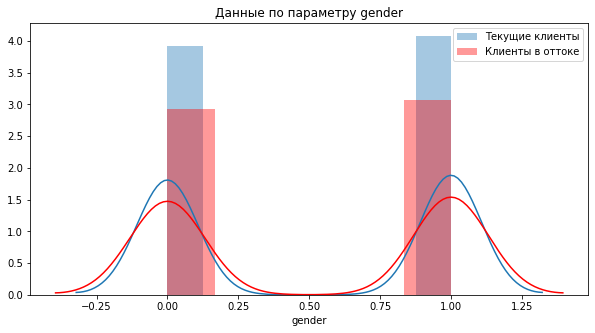

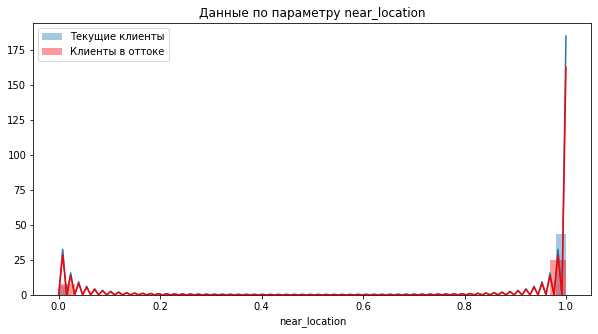

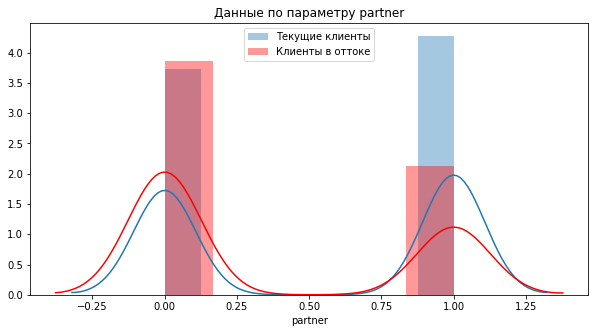

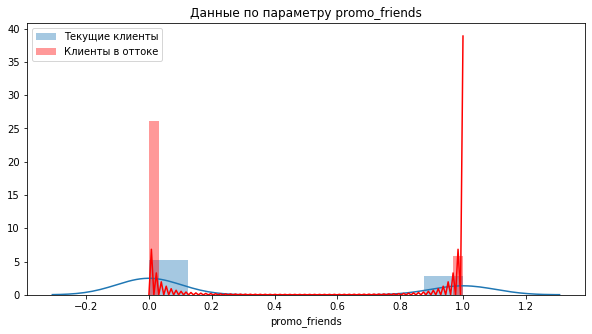

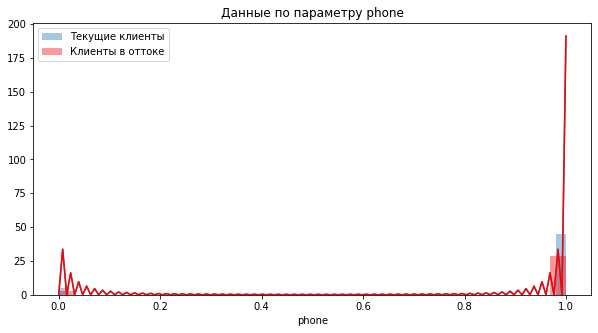

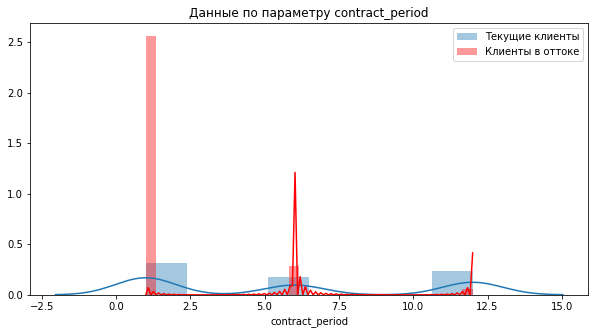

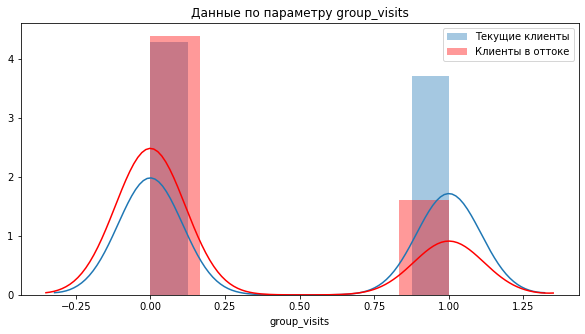

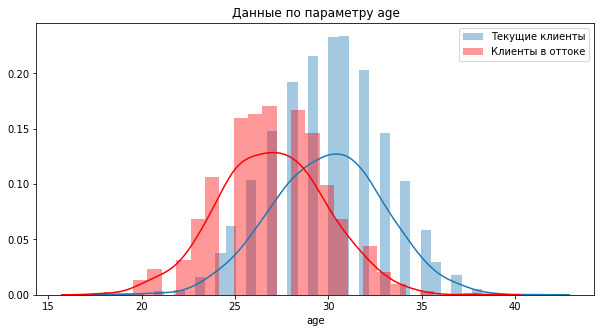

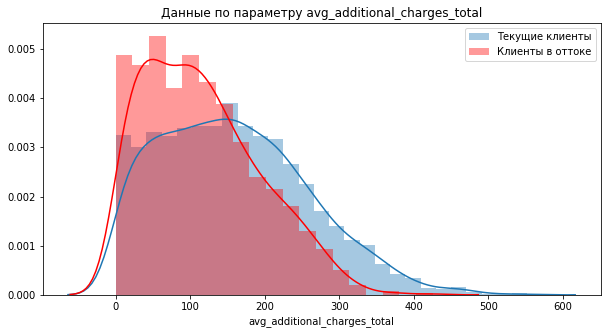

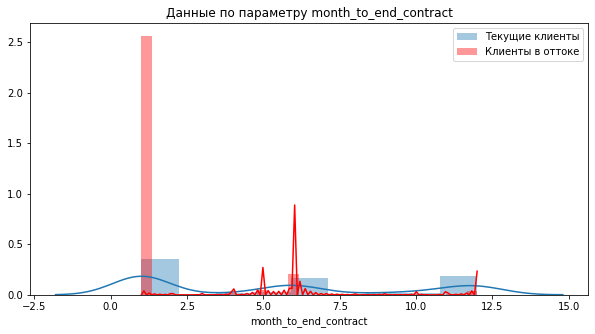

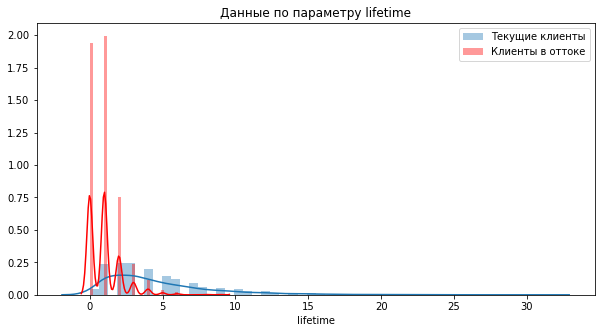

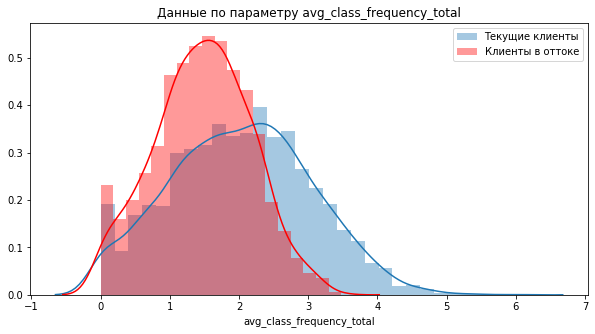

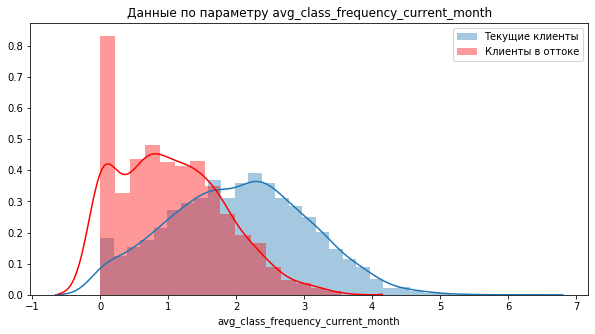

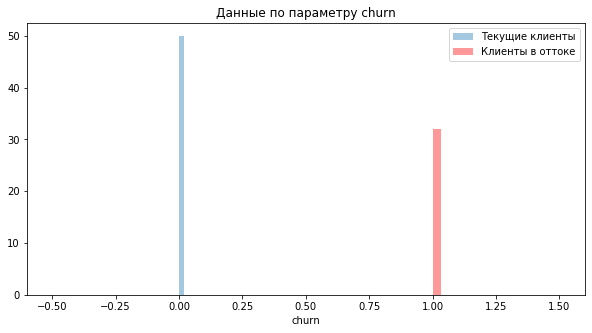

In [8]:
for column in df.columns:
    plt.figure(figsize=(10, 5))
    sns.distplot(df[df['churn']==0][column])
    sns.distplot(df[df['churn']==1][column], color ='r')
    plt.legend(labels = ('Текущие клиенты', 'Клиенты в оттоке'))
    plt.title('Данные по параметру ' + column)
    plt.show()

По распределениям параметров можно выделить следующие особенность:

 - к оттоку склонны клиенты, чей средний возраст меньше
 - выручка с ушедших клиентов на доп. услуги меньше (видимо клиенты не покупали длительные абонементы на массаж и тд.)
 - наибольшее число клиентов на оттоке с длительность абонемента - месяц (у клиентов попросту закончился абонимент в следующем месяце)
 - ушедшие клиенты имеют сравнительно меньший lifetime (среди них доля постоянных клиентов видимо меньше)
 - среднее количество посещений в неделю (за предыдущий месяц) и месяц (за все время с начала действия абонемента) заметно меньше у ушедших клиентов, по сравнению с текущими клиентами (ушедшие клиенты менее активно посещали зал), если клиент ни разу не посещал зал за месяц, то с большой долей вероятности такой клиент уйдет в отток.

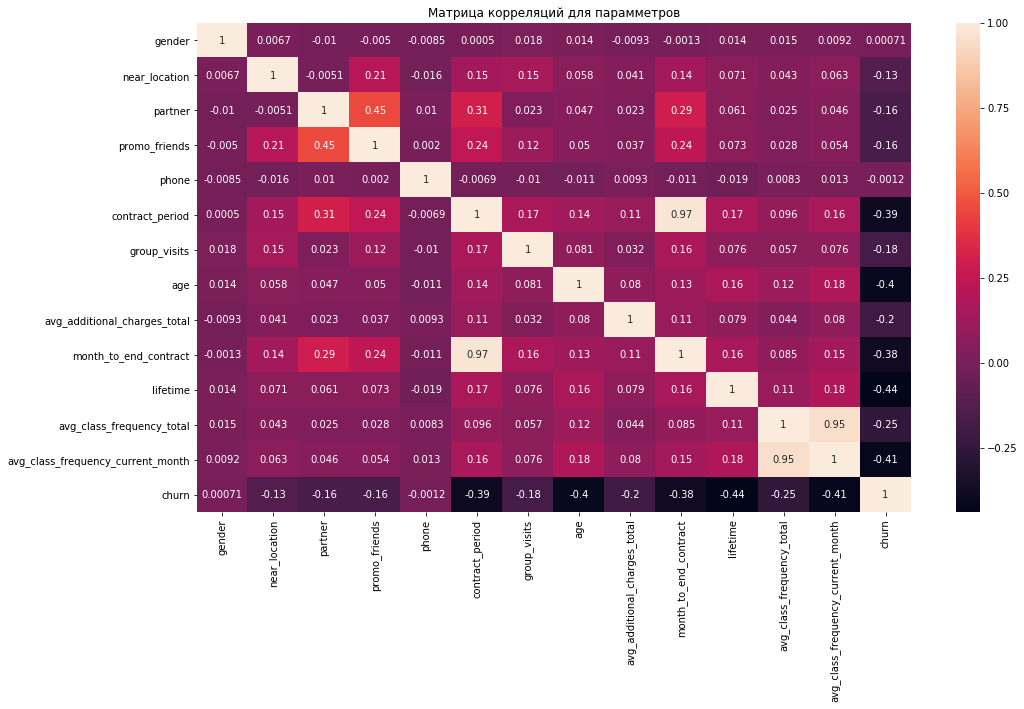

In [9]:
df_corr = df.corr()
plt.figure(figsize=(16, 9))
sns.heatmap(df_corr, annot=True)
plt.title('Матрица корреляций для парамметров')
plt.show()

В наших данных сильно коррелируют 2 пары парраметров:
1. 'Contract_period' и 'Month_to_end_contract' длительность абонимента с разных сторон (с начала и конца);
2. 'Avg_class_frequency_total' и 'Avg_class_frequency_current_month', частота посещений клиентами зала за разные отрезки времени.

Обе группы имеют логичную закономерность высокой корреляции, и рассматривают одну и туже переменную под разными углами.

## Постройте модель прогнозирования оттока клиентов

Построим модель бинарной классификации клиентов, где целевой признак — факт оттока клиента в следующем месяце. Разобьем данные на обучающую и валидационную выборку.

In [10]:
# разделяем данные на признаки (матрица X) и целевую переменную (y)
X = df.drop('churn', axis = 1)
y = df['churn']
# разделяем модель на обучающую и валидационную выборку
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

Обучим модель логической регрессией, поскольку регуляризация применяется по умолчанию в sklearn (L2 по умолчанию) не будем удалять столбцы с сильной корреляцией.

In [11]:
# стандартизируем данные методом StandartScaler
scaler = StandardScaler()
scaler.fit(X_train)
X_train_st = scaler.transform(X_train)
X_test_st = scaler.transform(X_test)

# зададим алгоритм для нашей модели
lg_model = LogisticRegression(random_state=0)

# обучим модель
lg_model.fit(X_train_st, y_train)

# воспользуемся уже обученной моделью, чтобы сделать прогнозы
lg_predictions = lg_model.predict(X_test_st)

# создадим датафрейм с признаками и их весами
features = pd.DataFrame({'feature': X_train.columns, 'coeff': lg_model.coef_[0]})
features['coeff_abs'] = abs(features['coeff'])
features.sort_values(by='coeff_abs', ascending=False)

,feature,coeff,coeff_abs
12,avg_class_frequency_current_month,-4.426492,4.426492
10,lifetime,-3.720057,3.720057
11,avg_class_frequency_total,3.290506,3.290506
7,age,-1.074359,1.074359
5,contract_period,-0.703741,0.703741
8,avg_additional_charges_total,-0.541020,0.541020
9,month_to_end_contract,-0.520089,0.520089
6,group_visits,-0.385778,0.385778
3,promo_friends,-0.268180,0.268180
2,partner,-0.082845,0.082845


Наибольший вес у параметра количества посищений, чем клиент чаще посещает зал, тем меньше шанс что он уйдет в отток.


In [12]:
rf_model = RandomForestClassifier(random_state=0)
rf_model.fit(X_train_st, y_train)
rf_predictions = rf_model.predict(X_test_st)
features = pd.DataFrame({'feature': X_train.columns, 'coeff': lg_model.coef_[0]})
features['coeff_abs'] = abs(features['coeff'])
features.sort_values(by='coeff_abs', ascending=False)

,feature,coeff,coeff_abs
12,avg_class_frequency_current_month,-4.426492,4.426492
10,lifetime,-3.720057,3.720057
11,avg_class_frequency_total,3.290506,3.290506
7,age,-1.074359,1.074359
5,contract_period,-0.703741,0.703741
8,avg_additional_charges_total,-0.541020,0.541020
9,month_to_end_contract,-0.520089,0.520089
6,group_visits,-0.385778,0.385778
3,promo_friends,-0.268180,0.268180
2,partner,-0.082845,0.082845


In [13]:
# функция для расчета метрик
def metrics (y_test, predictions):
    print('Accuracy: {:.2f}'.format(accuracy_score(y_test, predictions)))
    print('Precision: {:.2f}'.format(precision_score(y_test, predictions)))
    print('Recall: {:.2f}'.format(recall_score(y_test, predictions)))
    print('F1: {:.2f}'.format(f1_score(y_test, predictions)))

print('Метрики для логической регрессии:')
metrics(y_test, lg_predictions)

Метрики для логической регрессии:
Accuracy: 0.92
Precision: 0.85
Recall: 0.83
F1: 0.84


In [14]:
print('Метрики для случайного леса:')
metrics(y_test, rf_predictions)

Метрики для случайного леса:
Accuracy: 0.91
Precision: 0.83
Recall: 0.78
F1: 0.80


Судя по метрикам немного лучше себя показывает модель логической регрессии.

## Сделайте кластеризацию клиентов

Построим матрицу расстояний на стандартизованной матрице признаков и нарисуйем дендрограмму. 

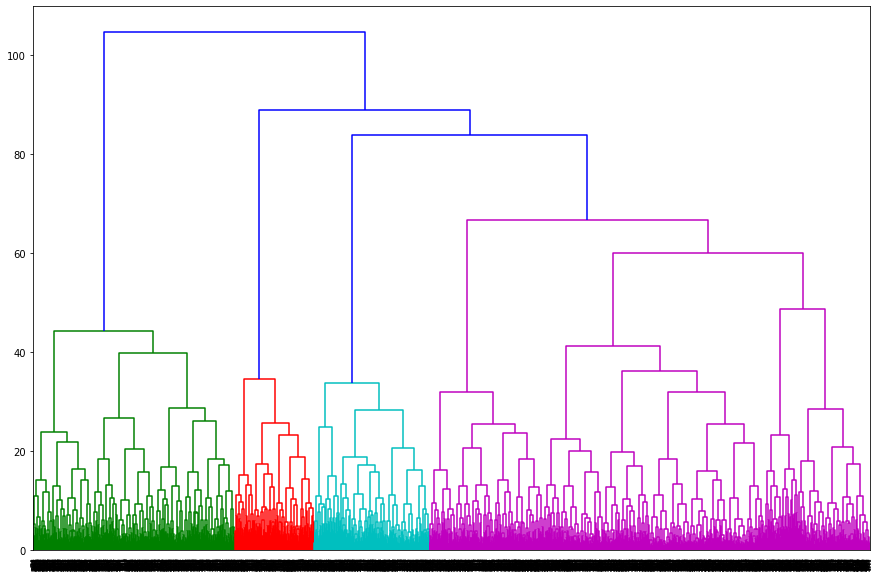

In [15]:
sc = StandardScaler()
X_sc = sc.fit_transform(df.drop('churn', axis = 1))
linked = linkage(X_sc, method = 'ward') 
plt.figure(figsize=(15, 10))  
dendrogram(linked, orientation='top')
plt.show() 

Судя по графику оптимальное можно выделить оптимальное количество кластеров от 4 до 8. В дальнейших вычислениях будем разбивать данные на 5 кластеров по условиям задачи.

In [16]:
# задаём число кластеров, равное 5
km = KMeans(n_clusters = 5)
# применяем алгоритм к данным и формируем вектор кластеров 
labels = km.fit_predict(X_sc) 
# сохраняем метки кластера в поле нашего датасета
df['cluster_km'] = labels
df_param_mean = df.groupby('cluster_km').mean()
df_param_mean.sort_values(by='churn')

,gender,near_location,partner,promo_friends,phone,contract_period,group_visits,age,avg_additional_charges_total,month_to_end_contract,lifetime,avg_class_frequency_total,avg_class_frequency_current_month,churn
cluster_km,,,,,,,,,,,,,,
3,0.503490,0.959123,0.782652,0.573280,1.000000,10.923230,0.546361,29.991027,160.881742,9.983051,4.748754,1.977676,1.970029,0.027916
4,0.560142,0.976415,0.359670,0.238208,0.998821,2.685142,0.469340,30.110849,161.665710,2.476415,4.889151,2.846441,2.844923,0.067217
0,0.522078,0.862338,0.470130,0.306494,0.000000,4.787013,0.425974,29.301299,143.957664,4.475325,3.924675,1.847220,1.716369,0.267532
1,0.495050,0.000000,0.463366,0.079208,1.000000,2.352475,0.215842,28.477228,135.457501,2.198020,2.809901,1.660461,1.477324,0.443564
2,0.484512,1.000000,0.351072,0.237490,1.000000,1.954726,0.341541,28.165210,131.444212,1.862589,2.430500,1.246208,1.011058,0.515488


Посмотрим на основной интересующий нас признак - это отток для каждого кластера. У кластера под номером 1 отток посетителей 3%, 3 - 7%, 2 - 27%, 4 - 44%, 0 - 51% соответственно. Если сравнивать остальные параметры на примере кластеров с самым высоким и самым низким оттоком, то видим, что по многим показателям среднее значение активности посетителей заметно отличается (например, срок абонемента, посещение групповых занятий, средняя посещаемость зала выше у кластера с низким оттоком). Получается, чем активнее клиент, тем вероятность его оттока гораздо ниже.

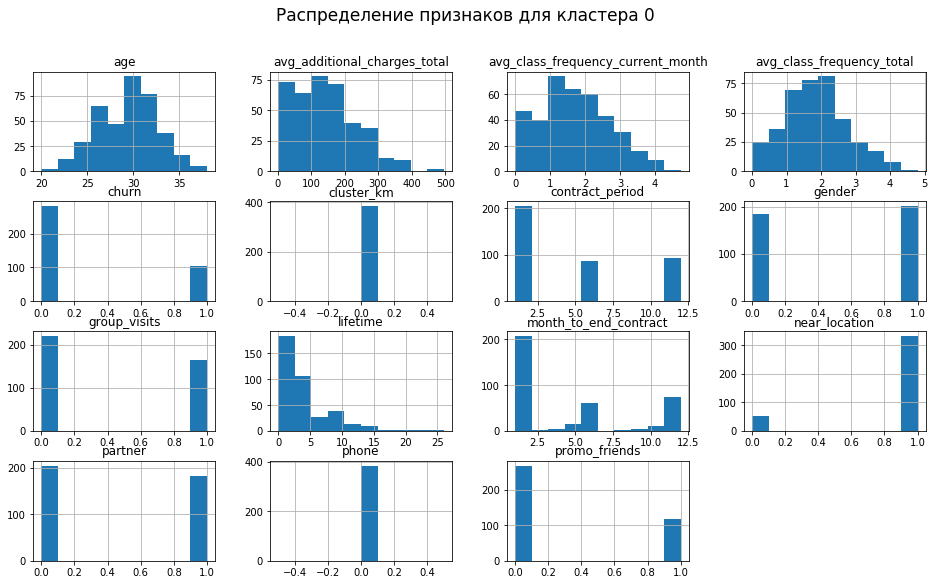

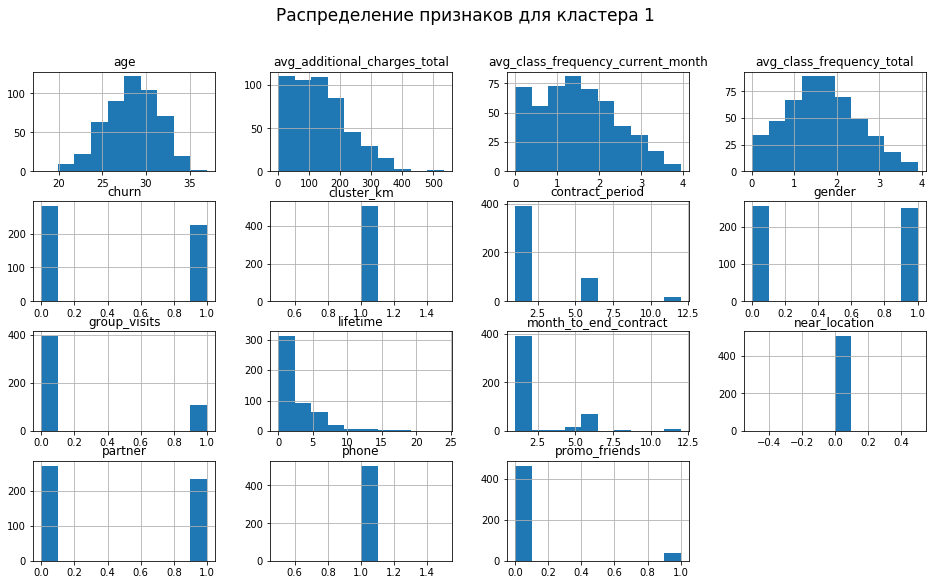

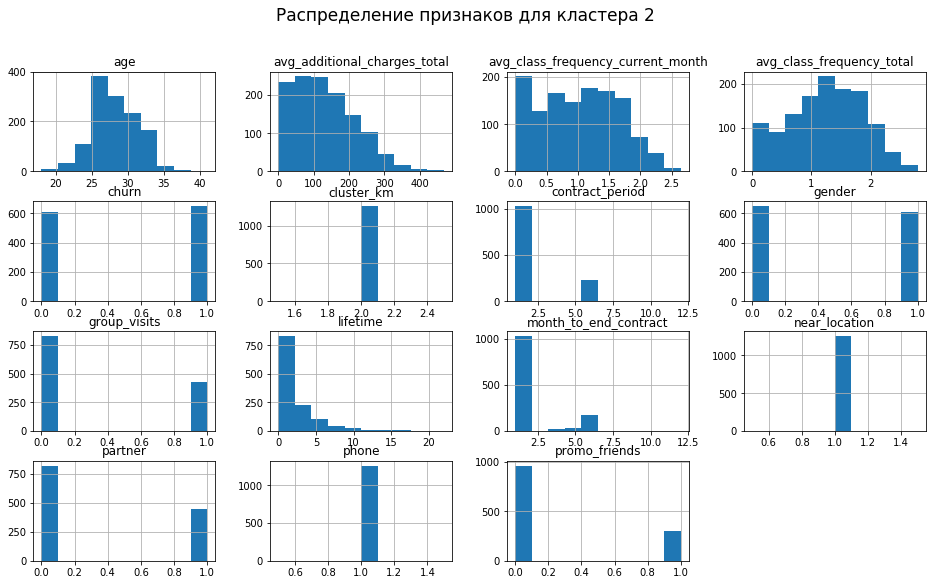

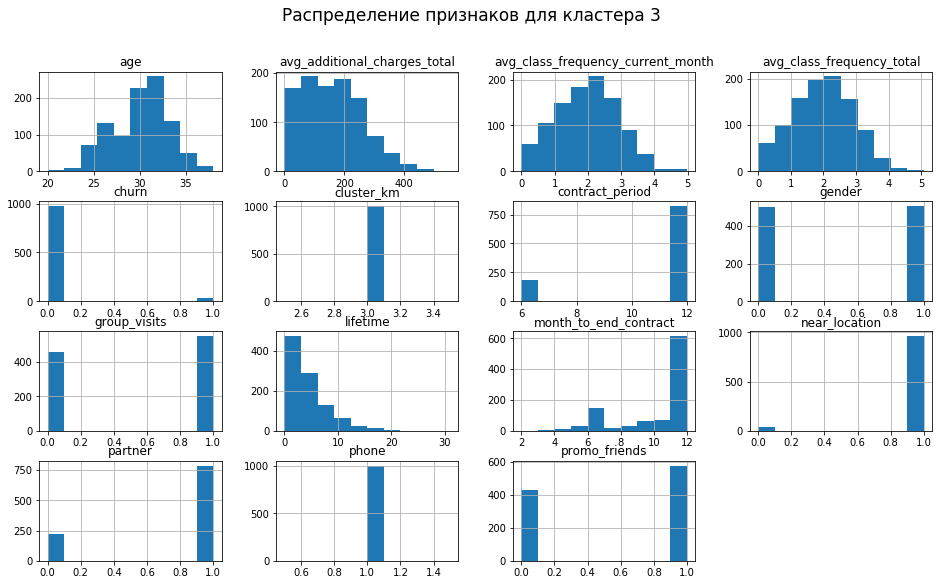

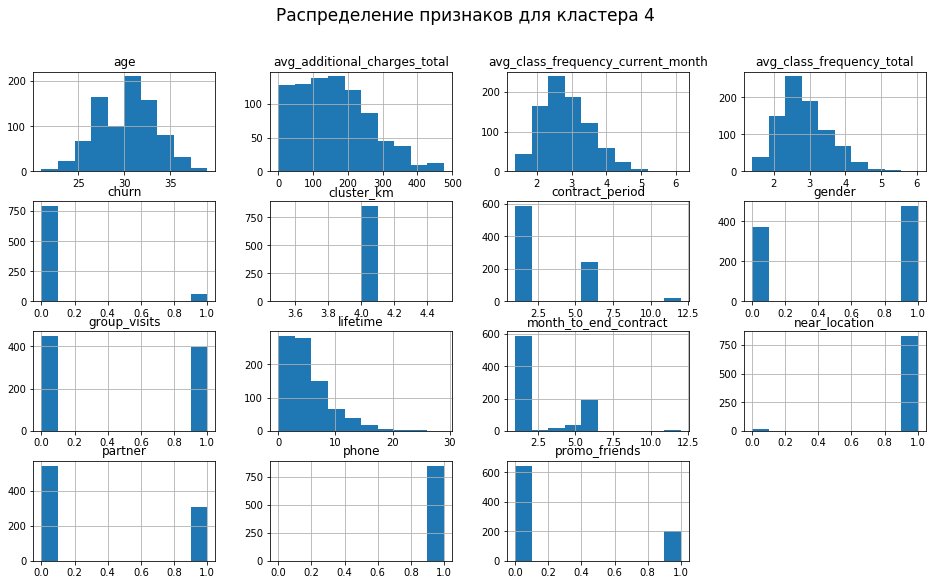

In [17]:
for val in [0, 1, 2, 3, 4]:
    df[df['cluster_km']==val].hist(figsize=(16,9))
    plt.suptitle('Распределение признаков для кластера {}'.format(val), fontsize = 17)
    plt.title(val)

Для каждого кластера характерно:

**Кластер 0:**
  - отток клиентов 51%;
  - самая низкая выручка за доп. услуги;
  - низкие сроки до окончания абонемента;
  - самый низкий lifetime клиентов;
  - зачастую проживают или работают около фитнес центра.
  
**Кластер 1:**
  - отток клиентов 3%;
  - наибольшая доля сотрудников компании - партнёров клуба;
  - самые длинные абонементы;
  - наибольшая доля посещения групповых занятий;
  - высокие показатeль lifetimе;
  - 57% пришедших по акции "приведи друга".
  

**Кластер 2:**
  - отток клиентов 27%;
  - ни один из пользователей не указал телефон;
  - средняя продолжительность абонемента 5 месяцев.
 
**Кластер 3:**
 - отток клиентов 7%;
 - 97% клиентов проживают или работают рядом с фитнес центром;
 - в данном кластере самые активные клиенты по посещению фитнес центра;
 - лучшие показатели по метрике lifetime;
 - самые большие затраты на доп услуги.
 
**Кластер 4:**
 - отток клиентов 44%;
 - всего 7% клиентов пришедших по акции "приведи друга";
 - хуже всех посещают групповые занятия.

## Общий вывод

На ввод нами были получены и проанализированы данные на месяц до оттока и факт оттока на определённый месяц клиентов фитнес центра. После проведения предобработки данных, мы посмотрели на средние значения показателей в разрезе клиентов ушедших в отток, и нет, при оценке параметров можно найти следующие закономерности:

 - клиенты, пришедшие по партнерской программе, уходят реже;
 - клиенты, пришедшие по промо акции "приведи друга, уходят реже;
 - у клиентов, чей срок абонемента больше, уходят реже;
 - клиенты, которые чаще посещают групповые тренировки уходят реже;
 - средний возраст клиентов, которые "оттекают", меньше;
 - суммрная выручка за дополнительные услуги, от клиентов, прекративших заниматься, была ниже;
 - чем меньше lifetime, тем больше вероятность оттока такого клиента;
 - у клиентов перед оттоком средняя посещаемость фитнес центра ниже.
 
Исходя из всех этих параметров можно сделать вывод, что чем больше клиент активен (и в плане посещений, и в плане доп. услуг), тем он лояльней к фитнес центру, и с меньшей вероятностью перестанет в него ходить.

В последующей работе мы анализировали данные на возможные корреляции параметров, для последующих построений моделей машинного обучения. В данных нашлись сильные взаимосвязи между двумя парами параметров. После чего приступили к построению моделей бинарной классификации клиентов. В качестве алгоритмов были выбраны: логическая регрессия и случайный лес. После анализа метрик немного более точной оказалась модель логической регрессии.
Далее проведена работа по кластеризации клиентов, в зависимости от признаков. На основании деления клиентов на кластеры можно сделать вывод, что:

 - в отток чаще уходят клиенты с маленьким сроком абонемента;
 - клиенты имеющие низкий lifetime (чем дольше клиент с нами, тем меньше вероятность у него уйти в отток);
 - клиенты пришедшие по промоакции "приведи друга" остаются с нами дольше;
 - чем активней клиент пользуется услугами или посещает центр, тем меньше вероятность у него уйти в отток.
 
 ### Рекомендации
 
На основании данных, можно сделать вывод, что общая активность клиентов - основной параметр для ежемесячного анализа. Для повышения активности необходимо:

 - проводить промоакции;
 - устраивать соревнования и конкурсы с призами;
 - улучшать сервис.
 
Для клиентов, чья активность падает, проводить стимулирующие работы, возможно стоит делать таким клиентом специальные скидки на дополнительные услуги (например,массаж, сауны, солярии и тд). Для новых клиентов необходимо поддерживать метрику lifetime, чем клиент с нами дольше, тем он лояльней и продолжительней пользуется нашими услугами. Стимулировать клиентов к покупке более продолжительных абонементов (например, за абонемент максимальной длины давать в подарок какую-ибудь из доп. услуг, тем самым будем "подсаживать" на использование этих доп. услуг). 

Проводить работу с клиентами которые ушли в отток (например, уточнять у них причину ухода для последующего анализа). Анализировать причины для возможной минимизации оттока. А для выявления потенциально уходящих клиентов использовать модель машинного обучения.